# Intra-Cluster Light (ICL) profiles analysis in the Dark Energy Survey (DES)




In [4]:
import healpy as hp
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from healpy.rotator import Rotator
import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample
from astropy.table import Table
import os
import os.path
import configparser
import sys
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
ini_file= 'redmapper_y1.ini'
config = configparser.ConfigParser()
inifile = config.read(ini_file)
input_dir_rdmp=config.get('input', 'input_dir')
catalog=config.get('input', 'catalog_file')
flag_files_rdmp=[ii.strip() for ii in config.get('input', 'flag_files').split(',')]
save_dir_rdmp=config.get('output', 'save_dir')
grid_output_dir_rdmp=config.get('grid_output', 'save_dir')
rdmp=pyfits.open(catalog)[1].data
flags_rdmp=np.zeros(len(rdmp))+1
indices_rdmp=np.arange(len(rdmp))

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             r'$\lambda$ = [60;$\infty$)']
richness_dir = ['richness_20_30/',
                'richness_30_45/',
                'richness_45_60/',
                'richness_60_beyond/']

# getting indices in the flag files
for file_flag in flag_files_rdmp:
    if os.path.isfile(file_flag):
        flag_dat=np.loadtxt(file_flag, dtype=[('index', int), ('flag', int)], skiprows=1)
        flag=flag_dat['flag']
        if len(flag) == len(flags_rdmp):
            flags_rdmp=flags_rdmp*flag

ind1, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 20) & (rdmp['lambda_chisq'] < 30))
print(len(ind1), len(indices_rdmp))
ind2, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 30) & (rdmp['lambda_chisq'] < 45))
print(len(ind2), len(indices_rdmp))
ind3, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 45) & (rdmp['lambda_chisq'] < 60))
print(len(ind3), len(indices_rdmp))
ind4, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 60) & (rdmp['lambda_chisq'] < 40000000))
print(len(ind4), len(indices_rdmp))

307 7066
152 7066
52 7066
32 7066


In [73]:
#inds = [ind1,ind2,ind3,ind4]
#for ij in range(4):
#    ngal_bins=ij
#    ind = inds[ngal_bins-1]
#    print('z = '+str(np.mean(rdmp['Z'][ind])))
    
ngal_bins=4
inds = [ind1,ind2,ind3,ind4]
ind = inds[ngal_bins-1]
Ncl = len(ind)
richness_dir = ['richness_20_30/',
                'richness_30_45/',
                'richness_45_60/',
                'richness_60_beyond/']

numflag = 4
flagrmem = ['', '_rmem_rlambda','_rmem_r200', '_rmem_scaled', '_2cuts', '_2cuts_r200'][numflag]

####
second_path_rdmp = 'rdmp6417_output_mask35_v2/'
dat_type=[('distance', float), ('mean', float), ('median', float)]
dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]

up_ind = np.loadtxt(dir_sub+'uprmem_indices_unmasked%s.txt'%(flagrmem))
up_ind = up_ind.astype(np.int64)
if numflag != 4 and numflag != 5:
    cen_ind = np.loadtxt(dir_sub+'cenrmem_indices_unmasked%s.txt'%(flagrmem))
    cen_ind = cen_ind.astype(np.int64)
low_ind = np.loadtxt(dir_sub+'lowrmem_indices_unmasked%s.txt'%(flagrmem))
low_ind = low_ind.astype(np.int64)

In [74]:
low_ind

array([  3,  10,  57,  60,  66, 101, 115, 124, 139, 143, 162, 164, 175,
       202, 242, 421])

## UP RMEM clusters

In [66]:
####
#x = new_profile['# xx']
#y = new_profile['r_mean'] 


dat_type=[('distance', float), ('mean', float), ('median', float)]
data_temp=Table.read(dir_sub+'subtracted_profile_uprmem_unmasked_%i%s.txt'%(up_ind[0],flagrmem), format='ascii')
ncluster=len(up_ind)
nbins=len(data_temp['# xx'])#20#399
yy_r=np.zeros([nbins, ncluster])+999999
xx=data_temp['# xx']
ct=0

for jji, jj in enumerate(up_ind):  # jji is an index from 0 to 356
                                # jj is the cluster id

    file_jj=dir_sub+'subtracted_profile_uprmem_unmasked_%i%s.txt'%(jj,flagrmem)
    if os.path.isfile(file_jj):
        data_sub=Table.read(file_jj, format='ascii')
        
        if len(data_sub['# xx'])==nbins: # nbins: length of the profile, number of radius bins
            yy_r[:, jji]=data_sub['r_mean']
            ct=ct+1
        else:
            print(jji)


print('total number of clusters to use: '+str(ct))
        

total number of clusters to use: 11


In [67]:
## jacknife sampling
from astropy.io.fits import Column

# getting the center position of rdmp clusters
coord_rdmp=np.transpose( np.array([rdmp[up_ind]['ra'], rdmp[up_ind]['dec']]) )
ncen = 40

if os.path.isfile('centers.txt') == 0: #this is false, so the code is jumping this part
    km = kmeans_sample(coord_rdmp, ncen, maxiter=100, tol=1.0e-5)
    print("found centers:",km.centers)
    print("converged?",km.converged)
    np.savetxt('centers.txt', km.centers)
centers=np.loadtxt('centers.txt')

# find the rdmp cluster closest to the center of the region:
labels_rdmp=kmeans_radec.find_nearest(coord_rdmp, centers)
print(labels_rdmp)
print(str(len(labels_rdmp))+' clusters')
print('  ')


len_kmeans=centers.shape[0] # 40, number of regions
os.system('mkdir '+save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/')
dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
os.system('mkdir '+dir_ind)

c0=Column(name='Jacknife_index', format='K')
c1=Column(name='x_axis', format='%iE'%nbins)
c2=Column(name='mean', format='%iE'%nbins)
cols = pyfits.ColDefs([c0, c1, c2])
hdu = pyfits.BinTableHDU.from_columns(cols, nrows=len_kmeans)

for ii in range(len_kmeans): # binning in kmean regions
    
    # subtracting clusters that belong to this region
    ind_rdmp,=np.where( (labels_rdmp != ii) )    
    print('region %i:'%(ii))
    print(str(len(labels_rdmp)-len(ind_rdmp))+' cluster(s) were removed')
    print(str(len(ind_rdmp))+' cluster(s) were used')
    print('')
    
    yyrmean_ind=np.zeros(nbins)    
    for jj in range(nbins): # binning in radius        
        temp_r_mean =yy_r[jj, :]        
        ind_temp, =np.where((temp_r_mean < 30000) & (temp_r_mean >-30000) & \
                            (labels_rdmp != ii) )        
        arr=temp_r_mean[ind_temp]
        yyrmean_ind[jj]=np.mean(arr)
        
    hdu.data[ii]['Jacknife_index']=ii
    hdu.data[ii]['x_axis']=xx
    hdu.data[ii]['mean']=yyrmean_ind

if os.path.isfile(dir_ind+'jacknife_profile_r_proper_kpc_uprmem_unmasked%s.fits'%(flagrmem)):
    os.remove(dir_ind+'jacknife_profile_r_proper_kpc_uprmem_unmasked%s.fits'%(flagrmem))
    
hdu.writeto(dir_ind+'jacknife_profile_r_proper_kpc_uprmem_unmasked%s.fits'%(flagrmem))



[35 19 19 34  3 27  5 18 28 20  6 33 10 33 34  8]
16 clusters
  
region 0:
0 cluster(s) were removed
16 cluster(s) were used

region 1:
0 cluster(s) were removed
16 cluster(s) were used

region 2:
0 cluster(s) were removed
16 cluster(s) were used

region 3:
1 cluster(s) were removed
15 cluster(s) were used

region 4:
0 cluster(s) were removed
16 cluster(s) were used

region 5:
1 cluster(s) were removed
15 cluster(s) were used

region 6:
1 cluster(s) were removed
15 cluster(s) were used

region 7:
0 cluster(s) were removed
16 cluster(s) were used

region 8:
1 cluster(s) were removed
15 cluster(s) were used

region 9:
0 cluster(s) were removed
16 cluster(s) were used

region 10:
1 cluster(s) were removed
15 cluster(s) were used

region 11:
0 cluster(s) were removed
16 cluster(s) were used

region 12:
0 cluster(s) were removed
16 cluster(s) were used

region 13:
0 cluster(s) were removed
16 cluster(s) were used

region 14:
0 cluster(s) were removed
16 cluster(s) were used

region 15:
0 cl

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


In [68]:
def jacknife_statistics(dat1, dat2 = np.zeros(1), bkg = 0):

    njack, narray = dat1.shape

    if dat1.shape != dat2.shape:
        dat2 = np.zeros([njack, narray]) # alternatively dat2 is 0
        print('no second array, using 0')
    mean = np.zeros(narray); err = np.zeros(narray)
    err_factor = np.sqrt(njack-1)

    for ii in range(narray):
        #bkg = 0 # dat1[:, narray-1] - dat2[:, narray-1] # 0 for default
        mean[ii] = np.mean(dat1[:, ii] - dat2[:, ii] - bkg)
        err[ii] = np.std(dat1[:, ii] - dat2[:, ii] - bkg) * err_factor
        
    return mean, err

binrich=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]

rdmp_jack = pyfits.open(binrich+'jacknife_profile_r_proper_kpc_uprmem_unmasked%s.fits'%(flagrmem))
mean_0, err_0 = jacknife_statistics(rdmp_jack[1].data['mean'])
xx_arr_0 = rdmp_jack[1].data['x_axis']

yyfactor=1.0/(0.263*cosmo.kpc_proper_per_arcmin(0.275).value/60.0)**2
np.savetxt(dir_ind+'sub_moments_uprmem_unmasked%s.txt'%(flagrmem), np.array([xx_arr_0[0], mean_0*yyfactor, err_0*yyfactor]).T, fmt='%f', header='# # xx, means, std')   
#np.savetxt(dir_ind+'sub_moments_uprmem.txt', np.array([xx_arr[0], mean*yyfactor, err*yyfactor]).T, fmt='%f', header='# # xx, means, std')   



no second array, using 0


no second array, using 0
no second array, using 0

No handles with labels found to put in legend.


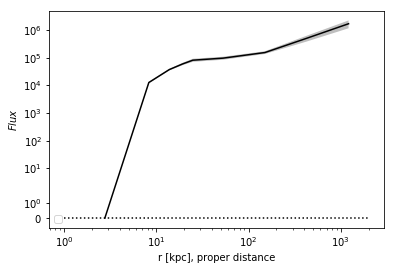

In [69]:
def integrate_flux(radius, dat1, dat2=np.zeros(1)):
    njack, narray = dat1.shape
    if dat1.shape != dat2.shape:
        dat2 = np.zeros([njack, narray]) # alternatively dat2 is 0
        print('no second array, using 0')

    return_arr = np.zeros([njack, narray]) # alternatively dat2 is 0
    bkg = 0 # dat1[:, narray-1] - dat2[:, narray-1] # 0 for default
    dat=dat1-dat2-bkg
    for ii in range(njack):
        xx_temp=radius
        yy_temp=dat[ii]*xx_temp
        yy_temp=np.insert(yy_temp, 0, yy_temp[0])
        xx_temp=np.insert(xx_temp, 0, 0)
        for kk in range(narray):
            return_arr[ii, kk]=np.trapz(yy_temp[0:kk+1], xx_temp[0:kk+1])*2.0*np.pi

    return return_arr

dat1=rdmp_jack[1].data['mean']
xx = rdmp_jack[1].data['x_axis']

integ_jack=integrate_flux(xx, dat1*yyfactor)
mean_int, err_int = jacknife_statistics(integ_jack)

z=zip(xx[0], mean_int, err_int);#np.savetxt('integrated'+filename, z, fmt='%f, %f, %f', header='# radius, integrated flux,uncertainty')
np.savetxt(dir_ind+'int_moments_uprmem_unmasked%s.txt'%(flagrmem), np.array([xx[0], mean_int, err_int]).T, fmt='%.18e', header='# xx, means, std')   


plt.fill_between(xx[0], (mean_int-err_int), (mean_int+err_int), facecolor='k', alpha=0.25)
plt.plot(xx[0], mean_int, color='k', label='')
#plt.plot(xx[0], mean_int*yyfactor, color='r', label='')

plt.plot([1, 2000], [0, 0], 'k:')
plt.xlabel('r [kpc], proper distance')
plt.ylabel(r'$Flux$')
plt.yscale('symlog');
plt.xscale('log');
plt.legend(loc=3)
plt.show()

no second array, using 0
no second array, using 0


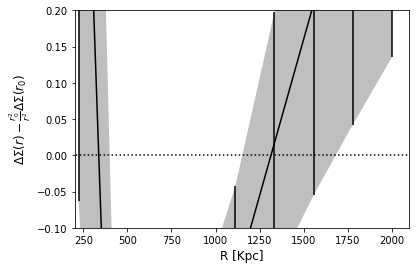

In [70]:
def first_delta_icl(rad, sigma, r0=260.698252):   
    integr = integrate_flux(rad, sigma)/(2.*np.pi)  
    return (2/(rad**2)) * integr - sigma

def delta_deltax(rad, delta, r0=260.698252):
    deltaxx = list(np.zeros(len(delta)))
    rmidxx = list(np.zeros(len(delta)))
    rmid = np.linspace(1,2001, 10)
    for kk in range(len(delta)):
        func=interp1d(rad[kk], delta[kk], fill_value = 'extrapolate')
        deltax = delta[kk] - func(r0)* (r0**2/rad[kk]**2)
        func2=interp1d(rad[kk], deltax, fill_value = 'extrapolate')
        deltaxx[kk]=func2(rmid)
        rmidxx[kk]=rmid
        
    return rmidxx, np.array(deltaxx)

from scipy.interpolate import interp1d

delta_jack=first_delta_icl(xx, dat1*yyfactor)
rmid, delta_icl2 = delta_deltax(xx, delta_jack, r0=260.698252)
mean_delt, err_delt = jacknife_statistics(delta_icl2)

mask = rmid[0]>100
np.savetxt(dir_ind+'delta_moments_uprmem_unmasked%s.txt'%(flagrmem), np.array([rmid[0][mask], mean_delt[mask], err_delt[mask]]).T, fmt='%f', header='# xx, means, std')   


plt.fill_between(rmid[0][mask], (mean_delt-err_delt)[mask], (mean_delt+err_delt)[mask], facecolor='k', alpha=0.25)
#plt.plot(rmid[0][mask], mean_delt[mask], color='k', label='')
plt.errorbar(rmid[0][mask], mean_delt[mask], yerr=np.array(err_delt[mask]), color='k',label='$\Delta \Sigma_{x}$')

plt.plot([1, 2100], [0, 0], 'k:')
plt.xlabel('R [Kpc]', fontsize=12)
plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
plt.xlim(200, 2100)
plt.ylim(-0.1, 0.2)
plt.show()

## CEN RMEM clusters

In [71]:
####
#x = new_profile['# xx']
#y = new_profile['r_mean'] 

if numflag != 4 and numflag != 5:

    dat_type=[('distance', float), ('mean', float), ('median', float)]
    data_temp=Table.read(dir_sub+'subtracted_profile_cenrmem_unmasked_%i%s.txt'%(cen_ind[1],flagrmem), format='ascii')
    ncluster=len(cen_ind)
    nbins=len(data_temp['# xx'])#20#399
    yy_r=np.zeros([nbins, ncluster])+999999
    xx=data_temp['# xx']
    ct=0

    for jji, jj in enumerate(cen_ind):  # jji is an index from 0 to 356
                                    # jj is the cluster id

        file_jj=dir_sub+'subtracted_profile_cenrmem_unmasked_%i%s.txt'%(jj,flagrmem)
        if os.path.isfile(file_jj):
            data_sub=Table.read(file_jj, format='ascii')

            if len(data_sub['# xx'])==nbins: # nbins: length of the profile, number of radius bins
                yy_r[:, jji]=data_sub['r_mean']
                ct=ct+1
            else:
                print(jji)


    print('total number of clusters to use: '+str(ct))


    ## jacknife sampling
    from astropy.io.fits import Column

    # getting the center position of rdmp clusters
    coord_rdmp=np.transpose( np.array([rdmp[cen_ind]['ra'], rdmp[cen_ind]['dec']]) )
    ncen = 40

    if os.path.isfile('centers.txt') == 0: #this is false, so the code is jumping this part
        km = kmeans_sample(coord_rdmp, ncen, maxiter=100, tol=1.0e-5)
        print("found centers:",km.centers)
        print("converged?",km.converged)
        np.savetxt('centers.txt', km.centers)
    centers=np.loadtxt('centers.txt')

    # find the rdmp cluster closest to the center of the region:
    labels_rdmp=kmeans_radec.find_nearest(coord_rdmp, centers)
    print(labels_rdmp)
    print(str(len(labels_rdmp))+' clusters')
    print('  ')


    len_kmeans=centers.shape[0] # 40, number of regions
    os.system('mkdir '+save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/')
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    os.system('mkdir '+dir_ind)

    c0=Column(name='Jacknife_index', format='K')
    c1=Column(name='x_axis', format='%iE'%nbins)
    c2=Column(name='mean', format='%iE'%nbins)
    cols = pyfits.ColDefs([c0, c1, c2])
    hdu = pyfits.BinTableHDU.from_columns(cols, nrows=len_kmeans)

    for ii in range(len_kmeans): # binning in kmean regions

        # subtracting clusters that belong to this region
        ind_rdmp,=np.where( (labels_rdmp != ii) )    
        print('region %i:'%(ii))
        print(str(len(labels_rdmp)-len(ind_rdmp))+' cluster(s) were removed')
        print(str(len(ind_rdmp))+' cluster(s) were used')
        print('')

        yyrmean_ind=np.zeros(nbins)    
        for jj in range(nbins): # binning in radius        
            temp_r_mean =yy_r[jj, :]        
            ind_temp, =np.where((temp_r_mean < 30000) & (temp_r_mean >-30000) & \
                                (labels_rdmp != ii) )        
            arr=temp_r_mean[ind_temp]
            yyrmean_ind[jj]=np.mean(arr)

        hdu.data[ii]['Jacknife_index']=ii
        hdu.data[ii]['x_axis']=xx
        hdu.data[ii]['mean']=yyrmean_ind


    if os.path.isfile(dir_ind+'jacknife_profile_r_proper_kpc_cenrmem_unmasked%s.fits'%(flagrmem)):
        os.remove(dir_ind+'jacknife_profile_r_proper_kpc_cenrmem_unmasked%s.fits'%(flagrmem))


    hdu.writeto(dir_ind+'jacknife_profile_r_proper_kpc_cenrmem_unmasked%s.fits'%(flagrmem))

    binrich=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]

    rdmp_jack = pyfits.open(binrich+'jacknife_profile_r_proper_kpc_cenrmem_unmasked%s.fits'%(flagrmem))
    mean_0, err_0 = jacknife_statistics(rdmp_jack[1].data['mean'])
    xx_arr_0 = rdmp_jack[1].data['x_axis']

    yyfactor=1.0/(0.263*cosmo.kpc_proper_per_arcmin(0.275).value/60.0)**2
    np.savetxt(dir_ind+'sub_moments_cenrmem_unmasked%s.txt'%(flagrmem), np.array([xx[0], mean_0*yyfactor, err_0*yyfactor]).T, fmt='%f', header='# # xx, means, std')   
    #np.savetxt(dir_ind+'sub_moments_lcenrmem.txt', np.array([xx_arr[0], mean*yyfactor, err*yyfactor]).T, fmt='%f', header='# # xx, means, std')   

    dat1=rdmp_jack[1].data['mean']
    xx = rdmp_jack[1].data['x_axis']

    integ_jack=integrate_flux(xx, dat1*yyfactor)
    mean_int, err_int = jacknife_statistics(integ_jack)

    z=zip(xx[0], mean_int, err_int);#np.savetxt('integrated'+filename, z, fmt='%f, %f, %f', header='# radius, integrated flux,uncertainty')
    np.savetxt(dir_ind+'int_moments_cenrmem_unmasked%s.txt'%(flagrmem), np.array([xx[0], mean_int, err_int]).T, fmt='%f', header='# xx, means, std')   


    plt.fill_between(xx[0], (mean_int-err_int), (mean_int+err_int), facecolor='k', alpha=0.25)
    plt.plot(xx[0], mean_int, color='k', label='')
    #plt.plot(xx[0], mean_int*yyfactor, color='r', label='')

    plt.plot([1, 2000], [0, 0], 'k:')
    plt.xlabel('r [kpc], proper distance')
    plt.ylabel(r'$Flux$')
    plt.yscale('symlog')
    plt.xscale('log')
    plt.legend(loc=3)
    plt.show()


    from scipy.interpolate import interp1d

    delta_jack=first_delta_icl(xx, dat1*yyfactor)
    rmid, delta_icl2 = delta_deltax(xx, delta_jack, r0=260.698252)
    mean_delt, err_delt = jacknife_statistics(delta_icl2)

    mask = rmid[0]>100
    np.savetxt(dir_ind+'delta_moments_cenrmem_unmasked%s.txt'%(flagrmem), np.array([rmid[0][mask], mean_delt[mask], err_delt[mask]]).T, fmt='%f', header='# xx, means, std')   


    plt.fill_between(rmid[0][mask], (mean_delt-err_delt)[mask], (mean_delt+err_delt)[mask], facecolor='k', alpha=0.25)
    #plt.plot(rmid[0][mask], mean_delt[mask], color='k', label='')
    plt.errorbar(rmid[0][mask], mean_delt[mask], yerr=np.array(err_delt[mask]), color='k',label='$\Delta \Sigma_{x}$')

    plt.plot([1, 2100], [0, 0], 'k:')
    plt.xlabel('R [Kpc]', fontsize=12)
    plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
    plt.xlim(200, 2100)
    plt.ylim(-0.1, 0.2)
    plt.show()

## LOW RMEM clusters

total number of clusters to use: 16
[38 28  1  5 14  2 18 22  5 19  9 21  0 29  9  0]
16 clusters
  
region 0:
2 cluster(s) were removed
14 cluster(s) were used

region 1:
1 cluster(s) were removed
15 cluster(s) were used

region 2:
1 cluster(s) were removed
15 cluster(s) were used

region 3:
0 cluster(s) were removed
16 cluster(s) were used

region 4:
0 cluster(s) were removed
16 cluster(s) were used

region 5:
2 cluster(s) were removed
14 cluster(s) were used

region 6:
0 cluster(s) were removed
16 cluster(s) were used

region 7:
0 cluster(s) were removed
16 cluster(s) were used

region 8:
0 cluster(s) were removed
16 cluster(s) were used

region 9:
2 cluster(s) were removed
14 cluster(s) were used

region 10:
0 cluster(s) were removed
16 cluster(s) were used

region 11:
0 cluster(s) were removed
16 cluster(s) were used

region 12:
0 cluster(s) were removed
16 cluster(s) were used

region 13:
0 cluster(s) were removed
16 cluster(s) were used

region 14:
1 cluster(s) were removed
15 c

No handles with labels found to put in legend.


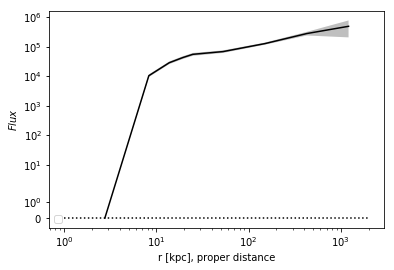

no second array, using 0
no second array, using 0


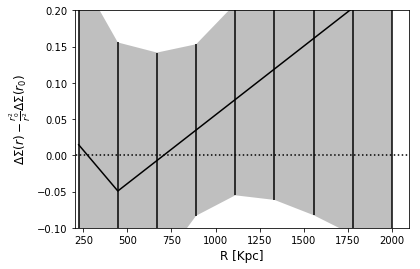

In [76]:
####
#x = new_profile['# xx']
#y = new_profile['r_mean'] 


dat_type=[('distance', float), ('mean', float), ('median', float)]
data_temp=Table.read(dir_sub+'subtracted_profile_lowrmem_unmasked_%i%s.txt'%(low_ind[1],flagrmem), format='ascii')
ncluster=len(low_ind)
nbins=len(data_temp['# xx'])#20#399
yy_r=np.zeros([nbins, ncluster])+999999
xx=data_temp['# xx']
ct=0

for jji, jj in enumerate(low_ind):  # jji is an index from 0 to 356
                                # jj is the cluster id

    file_jj=dir_sub+'subtracted_profile_lowrmem_unmasked_%i%s.txt'%(jj,flagrmem)
    if os.path.isfile(file_jj):
        data_sub=Table.read(file_jj, format='ascii')
        
        if len(data_sub['# xx'])==nbins: # nbins: length of the profile, number of radius bins
            yy_r[:, jji]=data_sub['r_mean']
            ct=ct+1
        else:
            print(jji)


print('total number of clusters to use: '+str(ct))
        

## jacknife sampling
from astropy.io.fits import Column

# getting the center position of rdmp clusters
coord_rdmp=np.transpose( np.array([rdmp[low_ind]['ra'], rdmp[low_ind]['dec']]) )
ncen = 40

if os.path.isfile('centers.txt') == 0: #this is false, so the code is jumping this part
    km = kmeans_sample(coord_rdmp, ncen, maxiter=100, tol=1.0e-5)
    print("found centers:",km.centers)
    print("converged?",km.converged)
    np.savetxt('centers.txt', km.centers)
centers=np.loadtxt('centers.txt')

# find the rdmp cluster closest to the center of the region:
labels_rdmp=kmeans_radec.find_nearest(coord_rdmp, centers)
print(labels_rdmp)
print(str(len(labels_rdmp))+' clusters')
print('  ')


len_kmeans=centers.shape[0] # 40, number of regions
os.system('mkdir '+save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/')
dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
os.system('mkdir '+dir_ind)

c0=Column(name='Jacknife_index', format='K')
c1=Column(name='x_axis', format='%iE'%nbins)
c2=Column(name='mean', format='%iE'%nbins)
cols = pyfits.ColDefs([c0, c1, c2])
hdu = pyfits.BinTableHDU.from_columns(cols, nrows=len_kmeans)

for ii in range(len_kmeans): # binning in kmean regions
    
    # subtracting clusters that belong to this region
    ind_rdmp,=np.where( (labels_rdmp != ii) )    
    print('region %i:'%(ii))
    print(str(len(labels_rdmp)-len(ind_rdmp))+' cluster(s) were removed')
    print(str(len(ind_rdmp))+' cluster(s) were used')
    print('')
    
    yyrmean_ind=np.zeros(nbins)    
    for jj in range(nbins): # binning in radius        
        temp_r_mean =yy_r[jj, :]        
        ind_temp, =np.where((temp_r_mean < 30000) & (temp_r_mean >-30000) & \
                            (labels_rdmp != ii) )        
        arr=temp_r_mean[ind_temp]
        yyrmean_ind[jj]=np.mean(arr)
        
    hdu.data[ii]['Jacknife_index']=ii
    hdu.data[ii]['x_axis']=xx
    hdu.data[ii]['mean']=yyrmean_ind

    
if os.path.isfile(dir_ind+'jacknife_profile_r_proper_kpc_lowrmem_unmasked%s.fits'%(flagrmem)):
    os.remove(dir_ind+'jacknife_profile_r_proper_kpc_lowrmem_unmasked%s.fits'%(flagrmem))
    
    
hdu.writeto(dir_ind+'jacknife_profile_r_proper_kpc_lowrmem_unmasked%s.fits'%(flagrmem))

binrich=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]

rdmp_jack = pyfits.open(binrich+'jacknife_profile_r_proper_kpc_lowrmem_unmasked%s.fits'%(flagrmem))
mean_0, err_0 = jacknife_statistics(rdmp_jack[1].data['mean'])
xx_arr_0 = rdmp_jack[1].data['x_axis']

yyfactor=1.0/(0.263*cosmo.kpc_proper_per_arcmin(0.275).value/60.0)**2
np.savetxt(dir_ind+'sub_moments_lowrmem_unmasked%s.txt'%(flagrmem), np.array([xx_arr_0[0], mean_0*yyfactor, err_0*yyfactor]).T, fmt='%f', header='# # xx, means, std')   
#np.savetxt(dir_ind+'sub_moments_lowrmem.txt', np.array([xx_arr[0], mean*yyfactor, err*yyfactor]).T, fmt='%f', header='# # xx, means, std')   

dat1=rdmp_jack[1].data['mean']
xx = rdmp_jack[1].data['x_axis']

integ_jack=integrate_flux(xx, dat1*yyfactor)
mean_int, err_int = jacknife_statistics(integ_jack)

z=zip(xx[0], mean_int, err_int);#np.savetxt('integrated'+filename, z, fmt='%f, %f, %f', header='# radius, integrated flux,uncertainty')
np.savetxt(dir_ind+'int_moments_lowrmem_unmasked%s.txt'%(flagrmem), np.array([xx[0], mean_int, err_int]).T, fmt='%f', header='# xx, means, std')   


plt.fill_between(xx[0], (mean_int-err_int), (mean_int+err_int), facecolor='k', alpha=0.25)
plt.plot(xx[0], mean_int, color='k', label='')
#plt.plot(xx[0], mean_int*yyfactor, color='r', label='')

plt.plot([1, 2000], [0, 0], 'k:')
plt.xlabel('r [kpc], proper distance')
plt.ylabel(r'$Flux$')
plt.yscale('symlog')
plt.xscale('log')
plt.legend(loc=3)
plt.show()


from scipy.interpolate import interp1d

delta_jack=first_delta_icl(xx, dat1*yyfactor)
rmid, delta_icl2 = delta_deltax(xx, delta_jack, r0=260.698252)
mean_delt, err_delt = jacknife_statistics(delta_icl2)

mask = rmid[0]>100
np.savetxt(dir_ind+'delta_moments_lowrmem_unmasked%s.txt'%(flagrmem), np.array([rmid[0][mask], mean_delt[mask], err_delt[mask]]).T, fmt='%f', header='# xx, means, std')   


plt.fill_between(rmid[0][mask], (mean_delt-err_delt)[mask], (mean_delt+err_delt)[mask], facecolor='k', alpha=0.25)
#plt.plot(rmid[0][mask], mean_delt[mask], color='k', label='')
plt.errorbar(rmid[0][mask], mean_delt[mask], yerr=np.array(err_delt[mask]), color='k',label='$\Delta \Sigma_{x}$')

plt.plot([1, 2100], [0, 0], 'k:')
plt.xlabel('R [Kpc]', fontsize=12)
plt.ylabel(r'$\Delta\Sigma(r) - \frac{r_{0}^{2}}{r^{2}} \Delta\Sigma(r_{0})$', fontsize=12)
plt.xlim(200, 2100)
plt.ylim(-0.1, 0.2)
plt.show()